# DASHBOARD

This notebook serves as a dashboard to reproduce what I had on Gravitus.

Date : 29 May 2022

@author: jeremylhour

# 1. Import packages and load the data

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import yaml
from datetime import datetime
from dateutil.relativedelta import relativedelta

from src.workout_tools import get_historical_performance, lbs_to_kg

plt.rcParams['figure.figsize'] = [14, 10]

CONFINEMENTS = [
    ("2020-03-17", "2020-05-11"),
    ("2020-10-30", "2020-12-15"),
    ("2021-04-03", "2021-05-03")
]

In [61]:
def plot_historical_e1RM(df, exercise, ax=None, rolling_window=15):
    """
    plot_historical_e1RM:
        plot estimated 1-rep max for a given exercise
    
    @param df (pd.DataFrame):
    @param exercise (str): name of the exercise
    """
    # the variable
    ts_var = df[exercise].dropna().sort_index().resample("W", label='left').max().rolling(f"{rolling_window}D").mean()
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(label=f'{exercise}, estimated 1-rep max (kg), {rolling_window} day-average')

    ax.plot(ts_var.index, ts_var, color="red")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator((1,4,7,10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("e1RM (kg)", color="red", fontsize=14)
    _=plt.xticks(rotation=30)
    
    for period in CONFINEMENTS:
        if ts_var.index.min() < pd.to_datetime(period[1]):
            ax.fill_between(period, ts_var.max()*1.1, color='grey', alpha=.5)

In [3]:
CONFIG_FILE = 'config/gravitus.yaml'

with open(CONFIG_FILE, 'r') as stream:
    config = yaml.safe_load(stream)

DATA_PATH = config.get('OUT_FOLDER')+"/"+str(config.get('USER_ID'))+"/parsed_data.json"

with open(DATA_PATH, 'rb') as f:
    workoutInfos = json.load(f)

In [4]:
TRACKER_FILE = 'config/tracker.yaml'

with open(TRACKER_FILE, 'r') as stream:
    tracker = yaml.safe_load(stream)

# 2. Process data

## A. Main process

In [5]:
EXERCISES = tracker.get("SBD") + tracker.get("EXTRA")
df = {}
for exercise in EXERCISES:
    print(f"Processing data for {exercise}...")
    df[exercise] = get_historical_performance(exercise, workoutInfos)

df = pd.concat(df, axis=1)
df.columns = EXERCISES

Processing data for Squat...
Processing data for Paused Bench Press...
Processing data for Deadlift...
Processing data for Overhead Press...


## B. Rapid cleaning

In [6]:
df.loc[df['Paused Bench Press'] > 150, 'Paused Bench Press'] = lbs_to_kg(df.loc[df['Paused Bench Press'] > 150, 'Paused Bench Press'])
df.loc[df['Overhead Press'] > 80, 'Overhead Press'] = lbs_to_kg(df.loc[df['Overhead Press'] > 80, 'Overhead Press'])

# 3. Historical charts

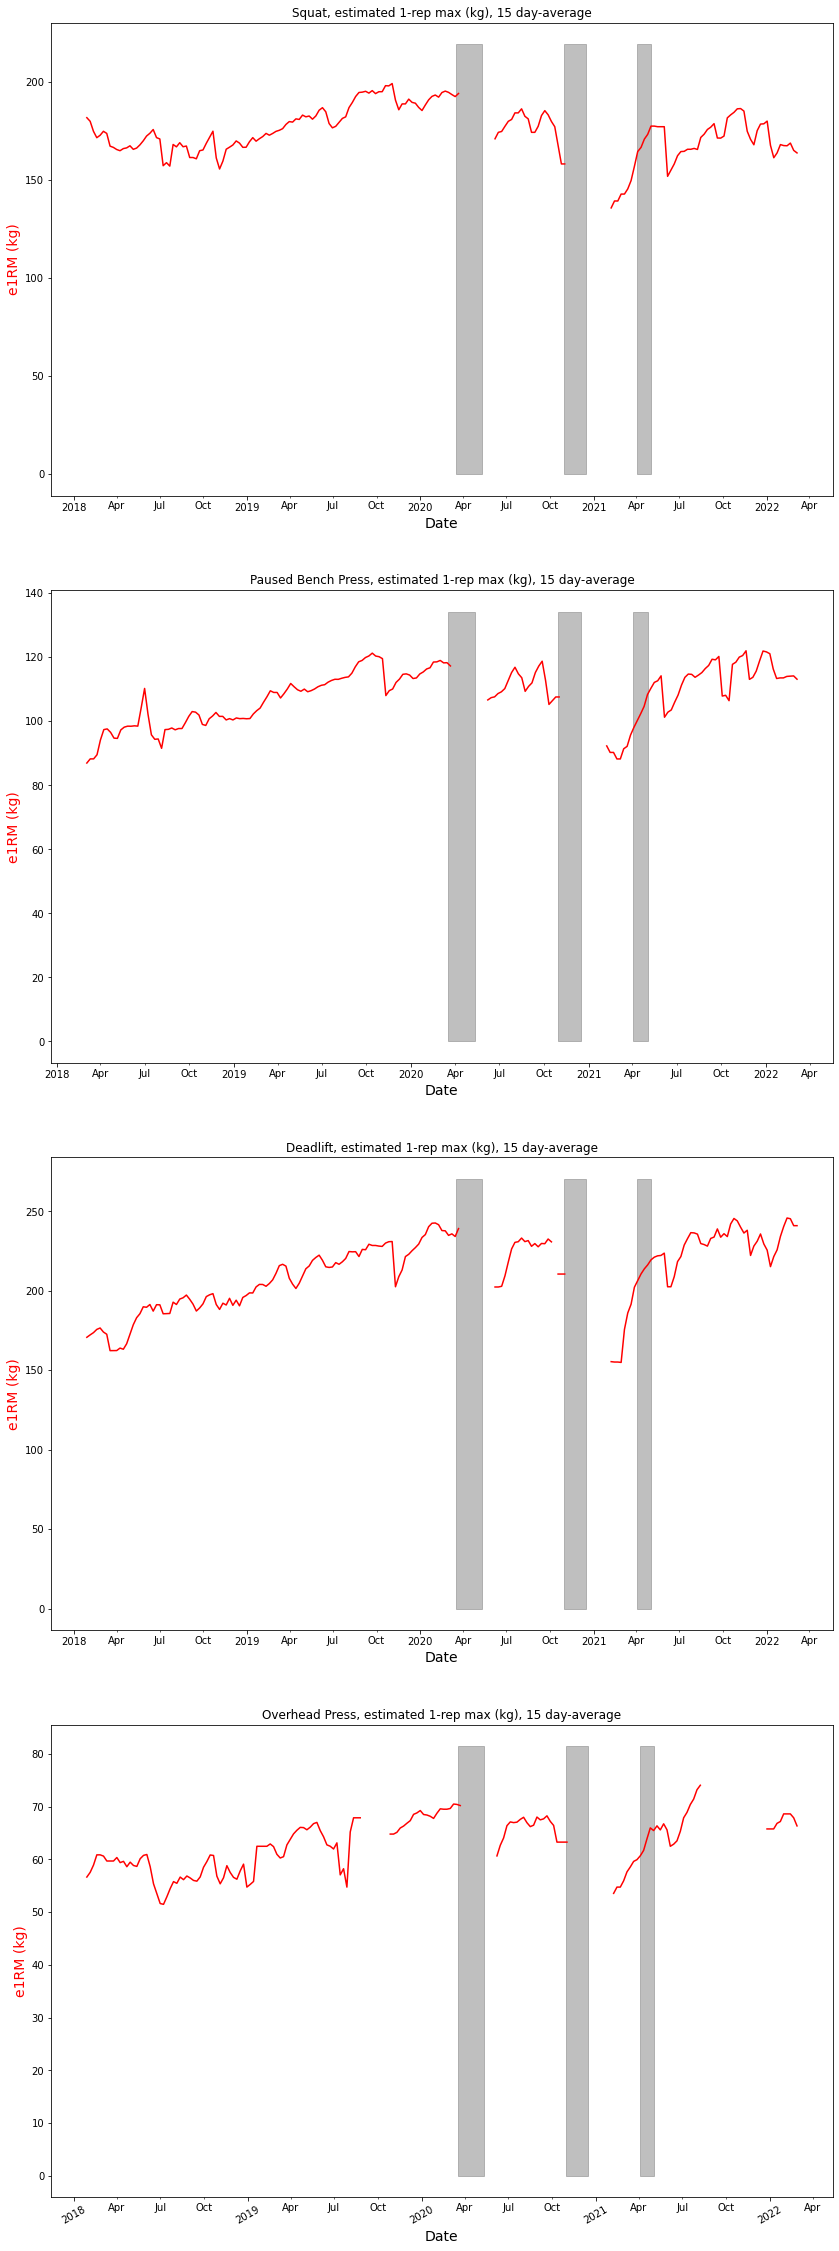

In [62]:
fig, ax = plt.subplots(len(EXERCISES), figsize=[14, 40])

for i, item in enumerate(EXERCISES):
    plot_historical_e1RM(df, item, ax[i])

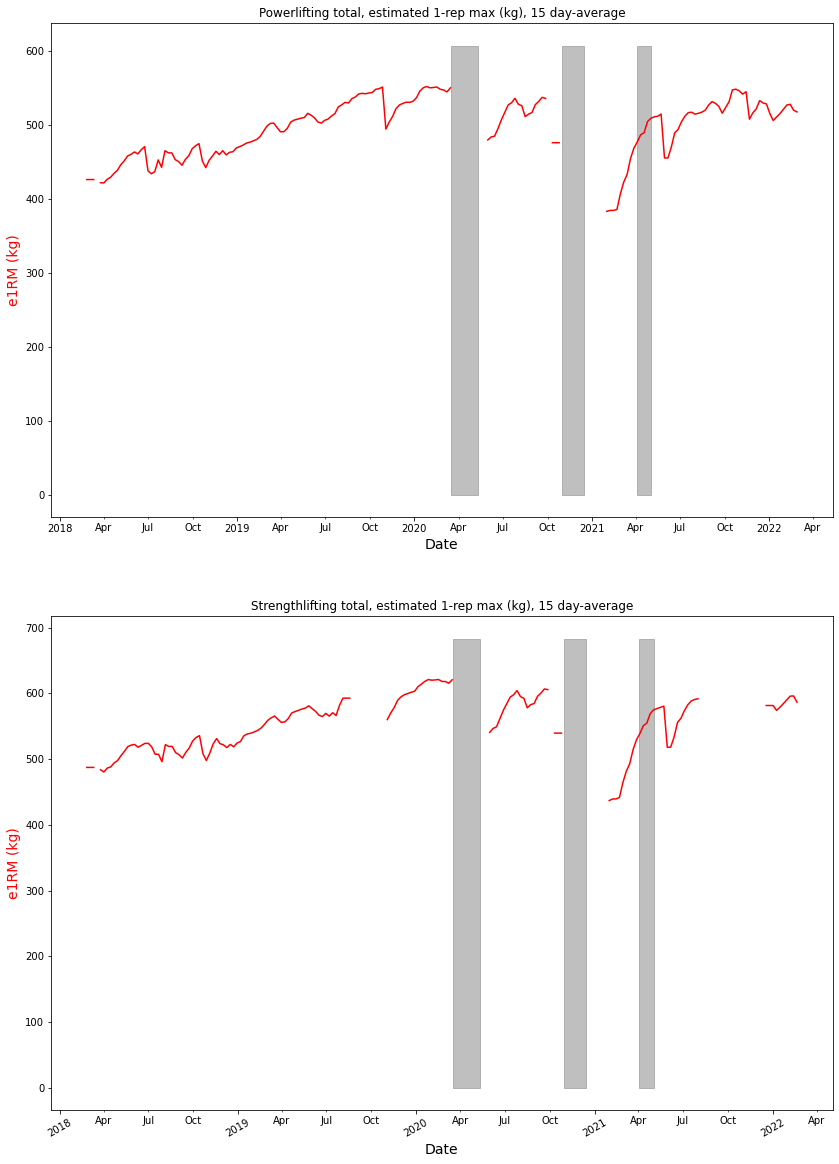

In [63]:
SBD_total = df["Squat"].resample("W", label='left').max() +\
            df["Paused Bench Press"].resample("W", label='left').max() +\
            df["Deadlift"].resample("W", label='left').max()

Strenghtlifting_total = SBD_total + df["Overhead Press"].resample("W", label='left').max()

total_df = pd.DataFrame({
    "Powerlifting total": SBD_total,
    "Strengthlifting total": Strenghtlifting_total
})

fig, ax = plt.subplots(2, figsize=[14, 20])

for i, item in enumerate(total_df.columns):
    plot_historical_e1RM(total_df, item, ax[i])

# 4. Yearly charts

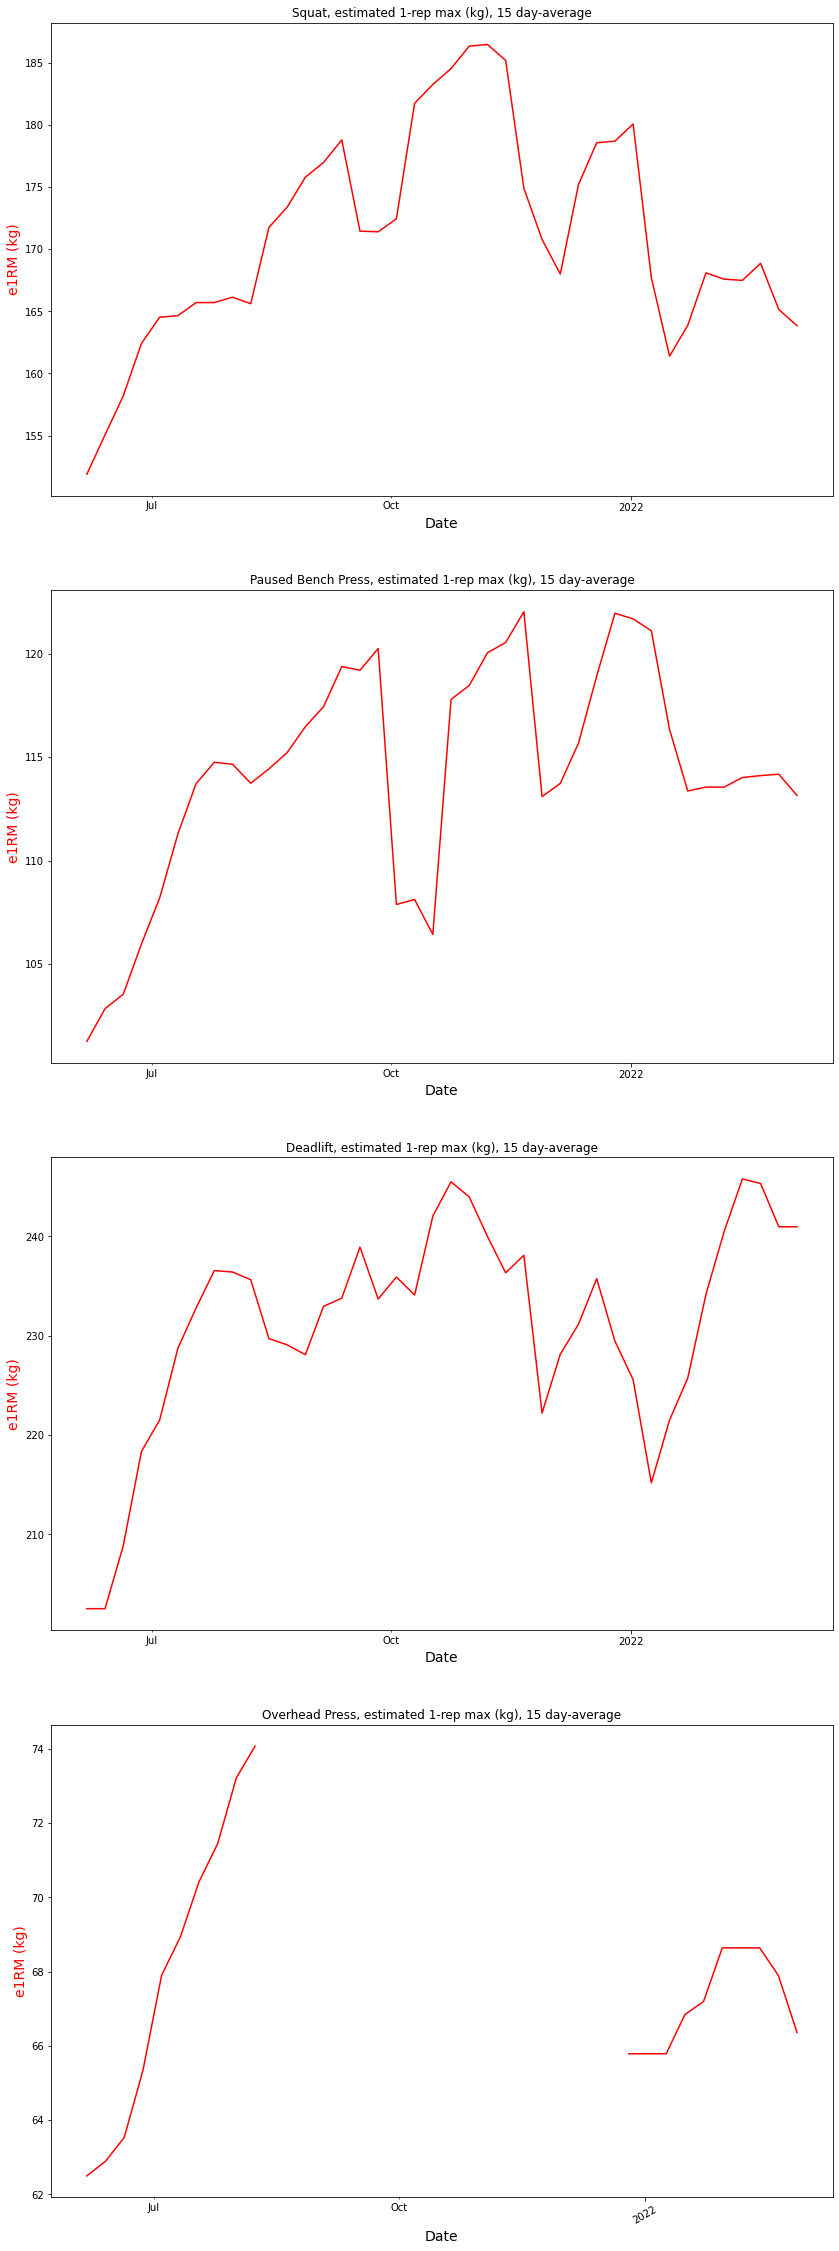

In [64]:
ONE_YEAR_AGO = datetime.now() - relativedelta(years=1)

fig, ax = plt.subplots(len(EXERCISES), figsize=[14, 40])

for i, item in enumerate(EXERCISES):
    plot_historical_e1RM(df[ONE_YEAR_AGO:], item, ax[i])

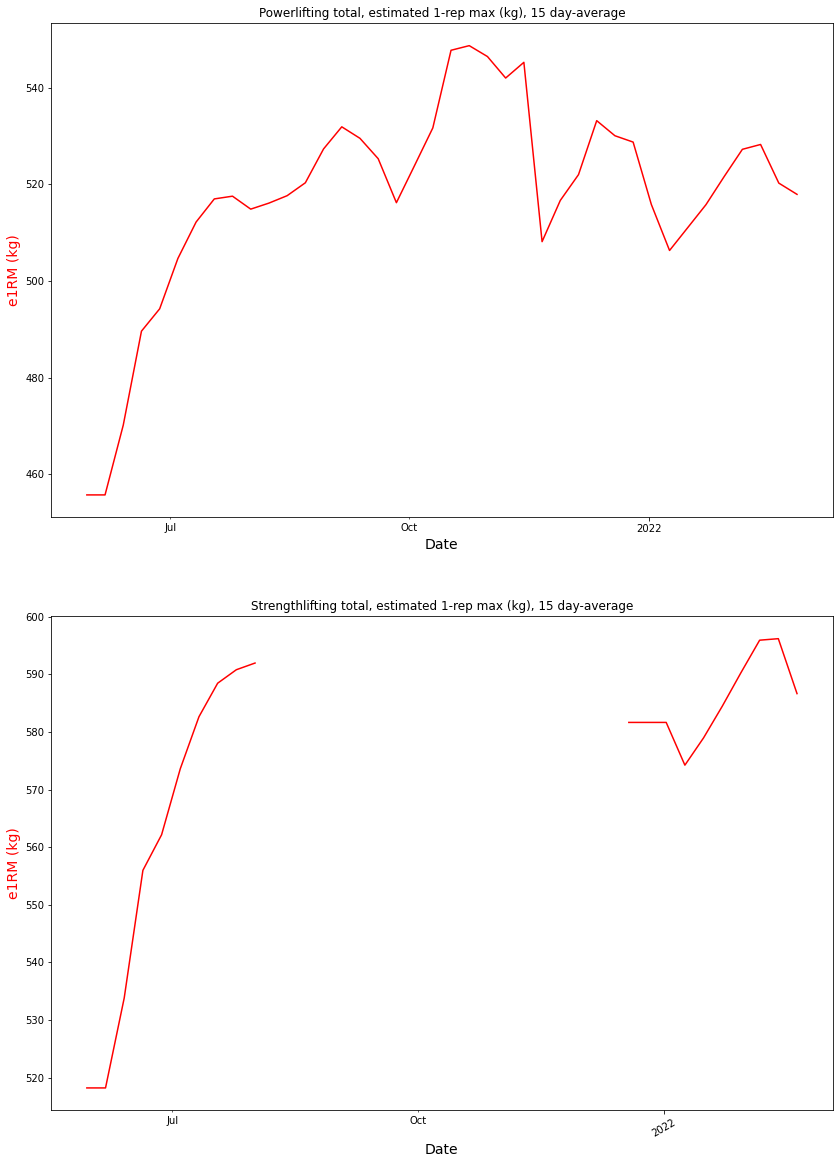

In [65]:
fig, ax = plt.subplots(2, figsize=[14, 20])

for i, item in enumerate(total_df.columns):
    plot_historical_e1RM(total_df[ONE_YEAR_AGO:], item, ax[i])